In [45]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)

<h3>NOTES</h3>
<ul>
    <li>We may be able to extrapolate latitude and longitude to fill in the missing values based on the county they are in</li>
    <li>We may be able to fill in missing gaps for magnitude by manually looking them up</li> 
    <li>We looked for specific county spending on infrastructure but were not able to find anything</li>
</ul>
    
TODO:
<ul>
    <li>Compare with and without estimate property</li>
    <li>Split all in test and training and get accuracies and errors</li>
    <li>Make heatmap plots for wildfires and thunderstorms</li>
    <li>include change in wind direction (azimuth) and begin and end direction</li>
</ul>

In [46]:
# Get the data
# column 1 = county name
# column 2 = begin location
# column 3 = begin date
# column 4 = begin time
# column 6 = magnitude
# column 10 = property damage
# column 11 = crops damage
# column 29 = end location
# column 30 = begin latitude
# column 31 = begin longitude
# column 32 = end latitude
# colunn 33 = end longitude

# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 2, 4, 6, 10, 11, 29, 30, 31, 32, 33])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 11 columns):
CZ_NAME_STR            315 non-null object
BEGIN_LOCATION         315 non-null object
BEGIN_TIME             315 non-null int64
MAGNITUDE              315 non-null float64
DAMAGE_PROPERTY_NUM    315 non-null int64
DAMAGE_CROPS_NUM       315 non-null int64
END_LOCATION           315 non-null object
BEGIN_LAT              315 non-null float64
BEGIN_LON              315 non-null float64
END_LAT                315 non-null float64
END_LON                315 non-null float64
dtypes: float64(5), int64(3), object(3)
memory usage: 27.1+ KB


In [47]:
# The outcomes
thunderstorm_outcomes = data.iloc[:, [4]]

list(thunderstorm_outcomes)

['DAMAGE_PROPERTY_NUM']

In [48]:
# The predictors
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR'], axis=1)

# NOTE: for right now crops damage is included, but we may want to see both with and without including this

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

In [49]:
# Make the outcomes into a numpy array
outcome_array = thunderstorm_outcomes.values.astype(np.float)
print('Shape of outcome array', outcome_array.shape)

# normalize outcome
outcome_array = (outcome_array - np.mean(outcome_array))/np.std(outcome_array)

# Make that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)

# Make the predictors into a numpy array
predictors_array = thunderstorm_predictors.values
# NOTE: we took out any missing data values in the csv 
print('Shape of inputs array', predictors_array.shape)

# Normalize inputs
predictors_array = (predictors_array - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array.astype(np.float))

# Convert those DoubleTensors to FloatTensors
# Chaning outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing the predictors too
predictors_Tensor = predictors_Tensor.float()

Shape of outcome array (315, 1)
Shape of inputs array (315, 7)


In [68]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 5)
        self.fc2 = torch.nn.Linear(5, 3)
        self.fc3 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
model = Net()

In [69]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

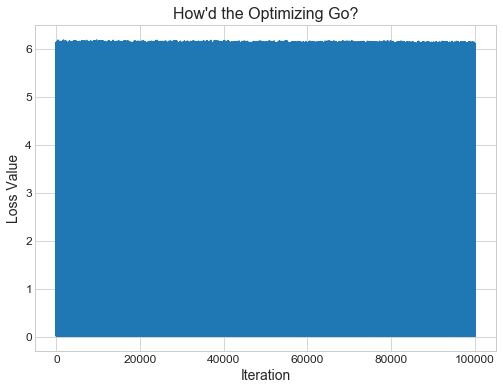

In [95]:
def train_neural_net(model, train_outcomes, train_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-1)
    
    # Train the neural network
    # 100000 iterations seems to give much better results when networks is two layers deep
    for t in range(100000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 100000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)
    
train_neural_net(model, outcome_Tensor, predictors_Tensor)

In [96]:
def plot_train_perf(train_predictors, train_obs):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

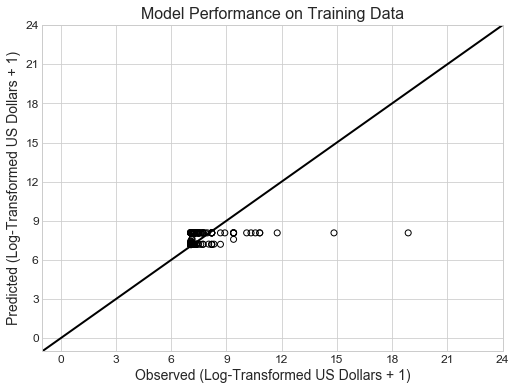

In [97]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

In [98]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [99]:
MSE = compute_MSE(predictors_Tensor, outcome_Tensor)
MSE

tensor(0.9940, grad_fn=<DivBackward0>)